In [1]:
import os
import sys
import eli5
import shap
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    auc
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.stats import lognorm, loguniform, randint
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_curve

## Loading Data, change encoding and Defining score metrics

In [2]:
# loading data from UCI ML Repository

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, skiprows=1)

# renaming the target variable

df.rename(columns = {"default payment next month":"target"}, inplace=True)

# dropping ID

df.drop(columns='ID', inplace=True)

# Changing numeric encoding to labels

df['SEX'].replace([1, 2], ['Male', 'Female'],
                  inplace=True)

df['MARRIAGE'].replace([1, 2, 3, 0],
                       ['Married', 'Single', 'Other', 'Other'], inplace=True)

df['EDUCATION'].replace([1, 2, 3, 4, 0, 5, 6],
                        ['GraduateSchool', 'University', 'HighSchool', 'Other',
                         'Other', 'Other', 'Other'], inplace=True)

In [3]:
# split the data 80/20

train_df, test_df = train_test_split(df, test_size=0.2, random_state=2)
train_df.shape

(24000, 24)

In [4]:
print(
    "Distribution of the target variable :\n",
    train_df["target"].value_counts(normalize=True), sep=''
)

Distribution of the target variable :
0    0.779125
1    0.220875
Name: target, dtype: float64


Class imbalance in the target variable.

In [5]:
# Separate X and Y for training and testing 
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [6]:
# evalution metric for scoring
f1_micro = make_scorer(f1_score, average="micro")

scoring = {
    "f1": f1_micro,
    "recall": "recall",
    "precision": "precision",
    'roc_auc': 'roc_auc'
}



## Exploratory Data Analysis

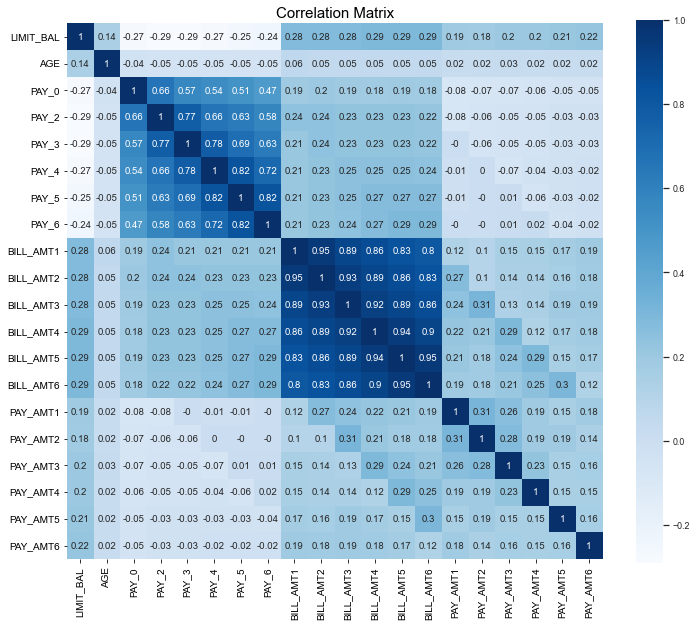

In [7]:
f, ax = plt.subplots(figsize=(12, 10))
corr = train_df.drop(columns=["target"]).corr().round(decimals=2)
sns.set(font_scale=0.8)
sns.heatmap(corr, cmap='Blues',
            square=True, ax=ax, annot=True)
plt.title('Correlation Matrix', fontsize=15)
plt.show();

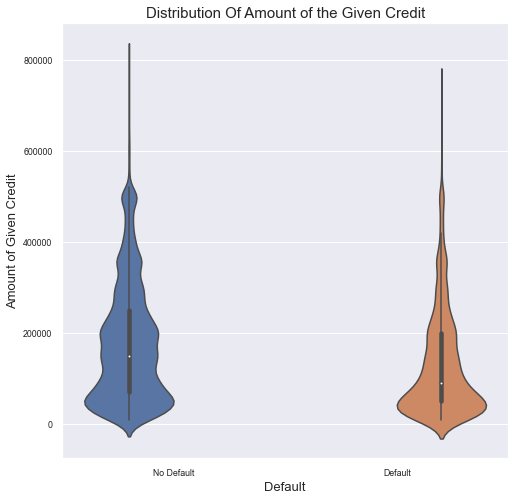

In [8]:
f, ax = plt.subplots(figsize=(8, 8))
violin= sns.violinplot(x="target",
                       y="LIMIT_BAL",
                       hue='target',
               data=train_df)
plt.title('Distribution Of Amount of the Given Credit', fontsize=15)
plt.legend().remove()
plt.xlabel('Default', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'No Default'
labels[1] = 'Default'
ax.set_xticklabels(labels)
plt.show();

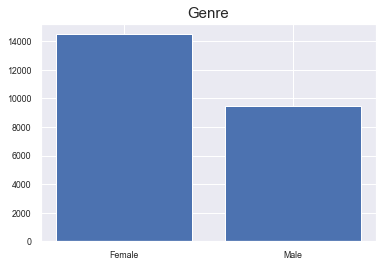

In [9]:
plt.bar(train_df['SEX'].unique().tolist(),
       train_df['SEX'].value_counts().tolist())
plt.title('Genre', fontsize=15);

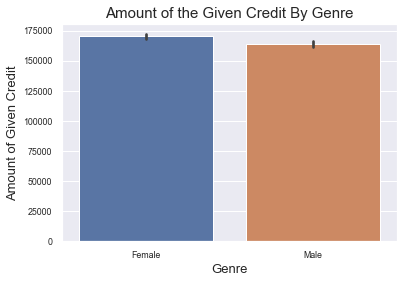

In [10]:
sns.barplot(x = 'SEX',y='LIMIT_BAL',data = df)
plt.xlabel('Genre', fontsize=13)
plt.ylabel('Amount of Given Credit', fontsize=13)
plt.title('Amount of the Given Credit By Genre', fontsize=15)
plt.show();

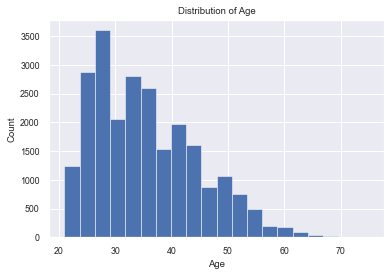

In [11]:
fig, ax = plt.subplots()
ax.hist(train_df['AGE'], bins=20, linewidth=0.5, edgecolor="white")
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.show();

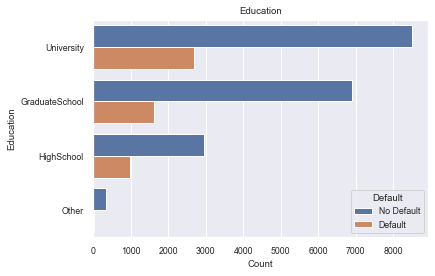

In [12]:
fig, ax = plt.subplots()
ax = sns.countplot(y="EDUCATION", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('Education')
plt.title('Education')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

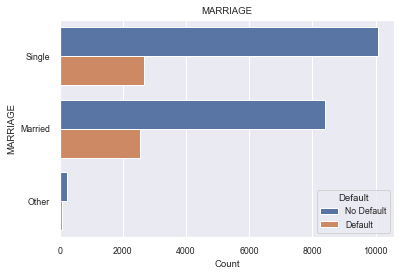

In [13]:
fig, ax = plt.subplots()
ax = sns.countplot(y="MARRIAGE", hue="target", data=train_df)
plt.xlabel('Count')
plt.ylabel('MARRIAGE')
plt.title('MARRIAGE')
plt.legend(title='Default', labels = ['No Default','Default'])
plt.show();

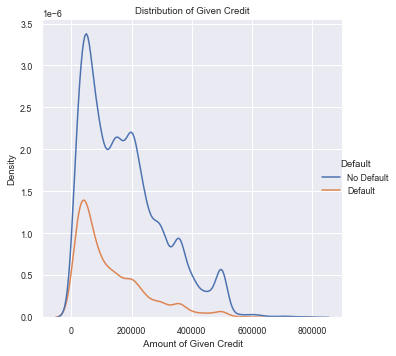

In [14]:
ax = sns.displot(x="LIMIT_BAL", hue="target", data=train_df, kind="kde")
ax.set(xlabel=' Amount of Given Credit', title='Distribution of Given Credit')
ax._legend.set_title('Default')
new_labels = ['No Default', 'Default']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
sns.move_legend(ax, "center right")

In [15]:
# Preprocessing and transformations

numeric_features = ["LIMIT_BAL", "AGE",
                    "PAY_0", "PAY_2",
                    "PAY_3", "PAY_4",
                    "PAY_5", "PAY_6",
                    'BILL_AMT1', 'BILL_AMT2',
                    'BILL_AMT3', 'BILL_AMT4',
                    'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2',
                    'PAY_AMT3', 'PAY_AMT4',
                    'PAY_AMT5', 'PAY_AMT6']

categorical_features = ["MARRIAGE"]

binary_features = ["SEX"]

ordinal_features = ["EDUCATION"]

education_levels = ['Other',  'HighSchool', 'University', 'GraduateSchool']


# preprocessor

preprocessor = make_column_transformer(

    (StandardScaler(), numeric_features),

    (
        OrdinalEncoder(categories=[education_levels], dtype=int),
        ordinal_features
    ),
    (OneHotEncoder(drop="if_binary"), binary_features),
    (
        OneHotEncoder(handle_unknown="ignore", sparse=False),
        categorical_features
    )

)

In [16]:
## Code attribution: UBC-MDS DSCI-571 Varada Kolhatkar 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## Modelling 

In [17]:
# Dictionary of Results

results = {}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVC": SVC(random_state=123),
    "Random Forest": RandomForestClassifier(random_state=123),
    "XGBoost": XGBClassifier(random_state=123, eval_metric="logloss",
                             verbosity=0, use_label_encoder=False,
                             class_weight="balanced"),
    "LightGBM": LGBMClassifier(random_state=123),
    "CatBoost": CatBoostClassifier(verbose=0,
                                   random_state=123)
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )

pd.DataFrame(results).T

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.218 (+/- 0.048),0.033 (+/- 0.007),0.810 (+/- 0.004),0.811 (+/- 0.001),0.233 (+/- 0.010),0.236 (+/- 0.008),0.720 (+/- 0.045),0.720 (+/- 0.004),0.721 (+/- 0.007),0.723 (+/- 0.002)
SVC,14.647 (+/- 0.366),8.026 (+/- 0.130),0.819 (+/- 0.005),0.824 (+/- 0.002),0.322 (+/- 0.017),0.335 (+/- 0.008),0.697 (+/- 0.032),0.716 (+/- 0.008),0.718 (+/- 0.007),0.780 (+/- 0.003)
Random Forest,4.520 (+/- 0.037),0.200 (+/- 0.001),0.816 (+/- 0.006),1.000 (+/- 0.000),0.363 (+/- 0.013),0.999 (+/- 0.000),0.648 (+/- 0.028),0.999 (+/- 0.000),0.760 (+/- 0.013),1.000 (+/- 0.000)
XGBoost,1.313 (+/- 0.009),0.064 (+/- 0.011),0.813 (+/- 0.006),0.895 (+/- 0.005),0.351 (+/- 0.013),0.584 (+/- 0.016),0.639 (+/- 0.029),0.908 (+/- 0.012),0.762 (+/- 0.010),0.954 (+/- 0.005)
LightGBM,0.287 (+/- 0.005),0.068 (+/- 0.004),0.819 (+/- 0.006),0.848 (+/- 0.003),0.359 (+/- 0.012),0.430 (+/- 0.011),0.673 (+/- 0.038),0.783 (+/- 0.011),0.775 (+/- 0.009),0.892 (+/- 0.002)
CatBoost,7.593 (+/- 0.889),0.089 (+/- 0.003),0.818 (+/- 0.007),0.857 (+/- 0.001),0.360 (+/- 0.012),0.462 (+/- 0.006),0.662 (+/- 0.033),0.811 (+/- 0.003),0.776 (+/- 0.008),0.896 (+/- 0.001)


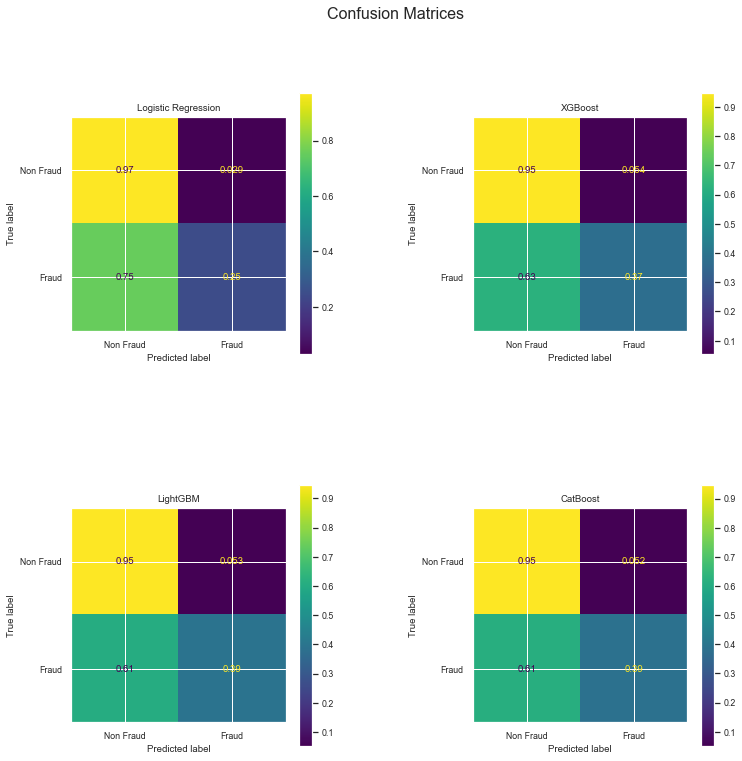

In [18]:
# Building Confusion Matrix

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,
                                             figsize=(12, 12))

fig.subplots_adjust(wspace = 0.5, hspace = 0.5 )

fig.suptitle("Confusion Matrices", horizontalalignment='center',
             fontsize=16)

axes = [ax1, None, None, ax2, ax3, ax4 ]
labels = ["Non Fraud", "Fraud"]

for (k, m), ax in zip(models.items(), axes):

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    ConfusionMatrixDisplay.from_estimator(

        pipe, X_test, y_test, ax=ax, display_labels=labels,
        normalize='true'
    )
    ax.set_title(f"{k}")

fig;

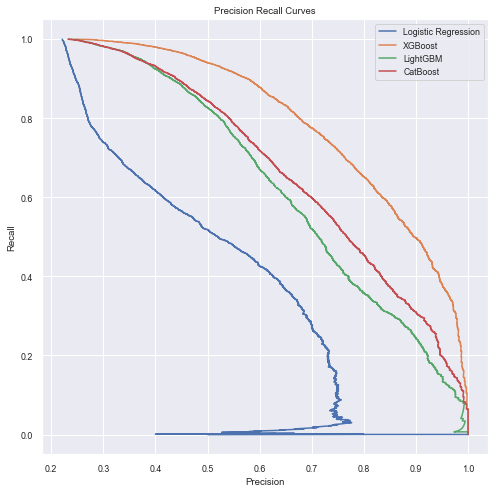

In [19]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = precision_recall_curve(
        y_train, pipe.predict_proba(X_train)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("Precision Recall Curves")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best");

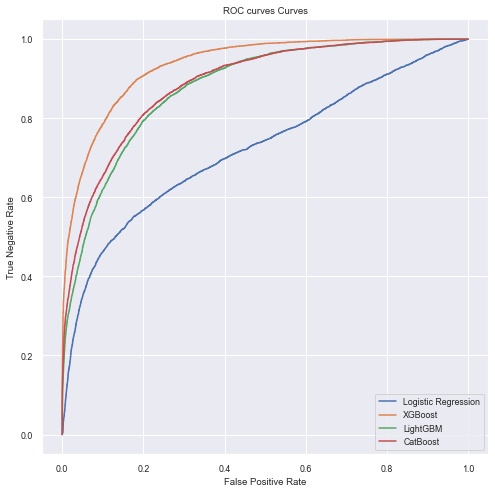

In [20]:
f, ax = plt.subplots(figsize=(8, 8))

for k, m in models.items():

    if (k == "Random Forest" or k == "SVC"):
        continue

    pipe = make_pipeline(preprocessor, m)
    pipe.fit(X_train, y_train);

    precision, recall, thresholds = roc_curve(
        y_train, pipe.predict_proba(X_train)[:, 1])

    plt.plot(precision, recall, label=k)

plt.title("ROC curves Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Negative Rate")
plt.legend(loc="best");

## Class Balancing - SMOTE 

In [21]:
results_smote = {}
for name, model in models.items():
    pipe = make_imb_pipeline(preprocessor,
                             SMOTE(),
                             model)
    results_smote[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring
    )

pd.DataFrame(results_smote).T

,fit_time,score_time,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision,test_roc_auc,train_roc_auc
Logistic Regression,0.836 (+/- 0.501),0.031 (+/- 0.006),0.675 (+/- 0.004),0.675 (+/- 0.004),0.648 (+/- 0.010),0.652 (+/- 0.004),0.367 (+/- 0.005),0.368 (+/- 0.003),0.722 (+/- 0.006),0.725 (+/- 0.002)
SVC,42.832 (+/- 1.330),18.825 (+/- 0.340),0.776 (+/- 0.009),0.788 (+/- 0.004),0.568 (+/- 0.015),0.597 (+/- 0.006),0.494 (+/- 0.017),0.517 (+/- 0.007),0.755 (+/- 0.009),0.800 (+/- 0.002)
Random Forest,7.597 (+/- 0.067),0.220 (+/- 0.006),0.797 (+/- 0.005),1.000 (+/- 0.000),0.457 (+/- 0.011),0.999 (+/- 0.000),0.550 (+/- 0.013),0.999 (+/- 0.000),0.753 (+/- 0.008),1.000 (+/- 0.000)
XGBoost,3.039 (+/- 0.278),0.061 (+/- 0.001),0.805 (+/- 0.007),0.885 (+/- 0.002),0.388 (+/- 0.012),0.597 (+/- 0.007),0.590 (+/- 0.025),0.835 (+/- 0.004),0.749 (+/- 0.007),0.936 (+/- 0.002)
LightGBM,0.878 (+/- 0.038),0.092 (+/- 0.007),0.813 (+/- 0.005),0.834 (+/- 0.003),0.415 (+/- 0.007),0.465 (+/- 0.010),0.613 (+/- 0.022),0.685 (+/- 0.009),0.768 (+/- 0.006),0.850 (+/- 0.002)
CatBoost,11.243 (+/- 0.325),0.088 (+/- 0.002),0.814 (+/- 0.005),0.853 (+/- 0.001),0.383 (+/- 0.010),0.489 (+/- 0.006),0.630 (+/- 0.022),0.761 (+/- 0.004),0.767 (+/- 0.007),0.894 (+/- 0.002)


## Hyperparameter Tunning LGBM

In [22]:
# Light GBM
pipe_lgbm = make_imb_pipeline(preprocessor, LGBMClassifier(random_state=123))

params = {
    "lgbmclassifier__boosting_type": ['gbdt', 'dart'],
    "lgbmclassifier__num_leaves ": randint(low=10, high=2000),
    "lgbmclassifier__n_estimators":randint(low=10, high=2000),
    "lgbmclassifier__class_weight": [None, "balanced"]
}

search = RandomizedSearchCV(
    pipe_lgbm,
    params,
    verbose=0,
    n_jobs=-1,
    n_iter=50,
    return_train_score=True,
    scoring= f1_micro,
    random_state=123,
)

search.fit(X_train, y_train);

[LightGBM] [Warning] num_leaves is set=31, num_leaves= will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] Unknown parameter: 960


In [23]:
print("Best score: %0.3f" % (search.best_score_))

print("Best hyperparameter values: ", search.best_params_)

Best score: 0.821
Best hyperparameter values:  {'lgbmclassifier__boosting_type': 'dart', 'lgbmclassifier__class_weight': None, 'lgbmclassifier__n_estimators': 369, 'lgbmclassifier__num_leaves ': 960}


In [24]:
b_type = search.best_params_['lgbmclassifier__boosting_type']
n_estimators= search.best_params_['lgbmclassifier__n_estimators']
num_leaves= search.best_params_['lgbmclassifier__num_leaves ']

In [25]:
pipe_lgbm_best = make_imb_pipeline(preprocessor,
                                   LGBMClassifier(random_state=123,
                                                  boosting_type=b_type,
                                                  n_estimators= n_estimators,
                                                  num_leaves= num_leaves))
pipe_lgbm_best.fit(X_train, y_train);

### Results

In [26]:
print(
    f"Grid Search best model validation score: {round(search.best_score_, 3)}"
)


print(f"Test f1 score:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")

Grid Search best model validation score: 0.821
Test f1 score:  0.814


In [27]:
print(f"Test f1 score - micro-average:  {round(f1_score(y_test, pipe_lgbm_best.predict(X_test), average= 'micro'), 3)}")
print(f"Test Accuracy score: {round(accuracy_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test Recall score: {round(recall_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test ROC_AUC score: {round(roc_auc_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")
print(f"Test precision score: {round(precision_score(y_test, pipe_lgbm_best.predict(X_test)), 3)}")

Test f1 score - micro-average:  0.814
Test Accuracy score: 0.814
Test Recall score: 0.394
Test ROC_AUC score: 0.664
Test precision score: 0.631


In [28]:
binary_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-1'].get_feature_names_out().tolist()

In [29]:
categorical_names = pipe_lgbm_best.named_steps["columntransformer"].named_transformers_['onehotencoder-2'].get_feature_names_out().tolist()

In [30]:
feature_names = numeric_features + ordinal_features + binary_names + categorical_names

In [31]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)


X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

lgbm_explainer = shap.TreeExplainer(pipe_lgbm_best.named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


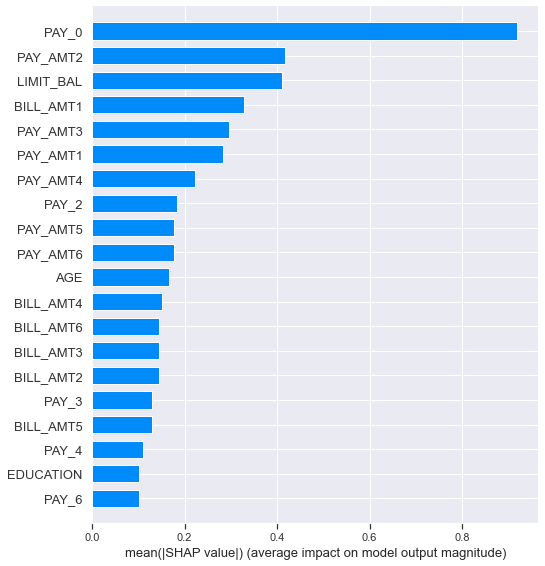

In [32]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")